In [2]:
import os,sys,shutil
from wand.image import Image as WImage
import numpy
import scipy.stats
import matplotlib.pyplot as plt
import nilearn.plotting
%matplotlib inline
import nibabel
from nipype.interfaces import fsl
from nipy.modalities.fmri.hemodynamic_models import spm_hrf,compute_regressor
from statsmodels.tsa.arima_process import arma_generate_sample
from __future__ import division

from nipype.caching import Memory
# use nipype's caching mechanism to save the results of the processing
mem = Memory(base_dir='.')

# set up rpy2 so we can use R magic
# %load_ext rpy2.ipython

datadir=os.getenv('FMRIBOOKDATA')
if not datadir:
    raise Exception('You need to set the environment variable FMRIBOOKDATA')
else:
    print 'using base dir:',datadir
sys.path.append('../../utils')

from get_data import get_data
data=get_data()

orig_figuredir='https://web.stanford.edu/group/poldracklab/fmri-handbook-2e-data/figures-1e/'

figuredir='../../figures'
if not os.path.exists(figuredir):
    os.mkdir(figuredir)

using base dir: /Users/poldrack/data/fmri-handbook-2e-data


__Figure 7.1__: Use manually generated original

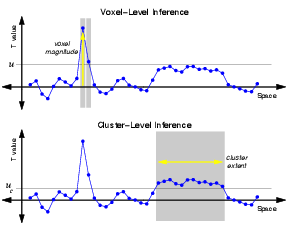

In [4]:
WImage(filename=os.path.join(orig_figuredir,'Figure_7_1.pdf'))

__Figure 7.2:__ Effects of cluster-forming threshold on cluster size. The same data were thresholded using increasing cluster-size thresholds; the resulting clusters are randomly color-coded to show which voxels belong to each cluster. At the lowest threshold, there is one large cluster that encompasses much of the brain, whereas higher thresholds break up this cluster, at the expense of excluding many regions that do not survive the higher threshold.

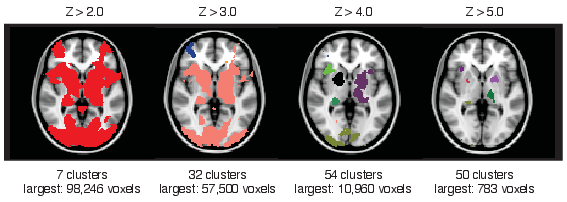

In [10]:
WImage(filename=os.path.join(orig_figuredir,'Figure_7_2.pdf'))

In [38]:
# first need to run group analysis on ds009 dataset
# using FSL

studydir=os.path.join(datadir,'ds009')
copefile=os.path.join(studydir,'task002_cope002_succstop.nii.gz')
varcopefile=os.path.join(studydir,'task002_varcope002_succstop.nii.gz')
nsubs=24
deshdr="""/NumWaves	1
/NumPoints	24
/PPheights		1.000000e+00

/Matrix"""

conhdr="""/ContrastName1	group mean
/NumWaves	1
/NumContrasts	1
/PPheights		1.000000e+00
/RequiredEffect		1.441

/Matrix"""

grouphdr="""/NumWaves	1
/NumPoints	24

/Matrix"""
desmtx=numpy.ones((nsubs,1))
numpy.savetxt('design.mat',desmtx,fmt='%1.0f',header=deshdr,comments='')
numpy.savetxt('covsplit.txt',desmtx,fmt='%1.0f',header=grouphdr,comments='')
conmtx=numpy.ones(1)
numpy.savetxt('design.con',conmtx,fmt='%1.0f',header=conhdr,comments='')

if not os.path.exists(os.path.join(studydir,'stats_OLS')):
    level2=mem.cache(fsl.FLAMEO)
    flameo_results = level2(cope_file=copefile, 
                        var_cope_file=varcopefile,
                        design_file='design.mat',
                        cov_split_file='covsplit.txt',
                        t_con_file='design.con',
                        mask_file=os.path.join(os.getenv('FSLDIR'),'data/standard/MNI152_T1_2mm_brain_mask_dil.nii.gz'),
                        run_mode='ols')

    flameo_results.outputs

    shutil.move(flameo_results.outputs.stats_dir,os.path.join(studydir,'stats_OLS'))


est = mem.cache(fsl.SmoothEstimate)
smoothness=est(dof=23,
    residual_fit_file = os.path.join(studydir,'stats_OLS/res4d.nii.gz'),
    mask_file = os.path.join(os.getenv('FSLDIR'),'data/standard/MNI152_T1_2mm_brain_mask_dil.nii.gz'))

print smoothness.outputs




/Users/poldrack/anaconda/lib/python2.7/site-packages/nipype/interfaces/base.py:419: UserWarning: Input residual_fit_file requires inputs: dof
  warn(msg)
INFO:workflow:Executing node 8f8a87b8b5e3c74fad1115c92894d07a in dir: /Users/poldrack/code/fmri-handbook-2e-code/notebooks/Chapter7-Inference/nipype_mem/nipype-interfaces-fsl-model-SmoothEstimate/8f8a87b8b5e3c74fad1115c92894d07a
INFO:workflow:Collecting precomputed outputs



dlh = 0.351483
resels = 13.3905
volume = 223953



In [44]:
# create outputs for different thresholds
cl = mem.cache(fsl.Cluster)
cluster_results={}

bgimage=nibabel.load(os.path.join(os.getenv('FSLDIR'),'data/standard/MNI152_T1_2mm_brain.nii.gz'))

for thresh in [2,3,4,5]:
    cluster_results[thresh]=cl(threshold = thresh,
       in_file = os.path.join(studydir,'stats_OLS/zstat1.nii.gz'),
        dlh=smoothness.outputs.dlh,
        volume=smoothness.outputs.volume,
        pthreshold=0.05,
        out_localmax_txt_file=os.path.join(studydir,'stats_OLS/zstat1_cluster_localmax_thresh%d.txt'%thresh),
        out_index_file=os.path.join(studydir,'stats_OLS/zstat1_cluster_index_thresh%d.nii.gz'%thresh),
        out_threshold_file=os.path.join(studydir,'stats_OLS/zstat1_thresh_thresh%d.nii.gz'%thresh))



/Users/poldrack/anaconda/lib/python2.7/site-packages/nipype/interfaces/base.py:419: UserWarning: Input pthreshold requires inputs: dlh, volume
  warn(msg)
INFO:workflow:Executing node 4282c2cb8bd0fba5aa3d6891f609873b in dir: /Users/poldrack/code/fmri-handbook-2e-code/notebooks/Chapter7-Inference/nipype_mem/nipype-interfaces-fsl-model-Cluster/4282c2cb8bd0fba5aa3d6891f609873b
INFO:workflow:Running: cluster --dlh=0.3514830000 --in=/Users/poldrack/data/fmri-handbook-2e-data/ds009/stats_OLS/zstat1.nii.gz --oindex=/Users/poldrack/data/fmri-handbook-2e-data/ds009/stats_OLS/zstat1_cluster_index_thresh2.nii.gz --olmax=/Users/poldrack/data/fmri-handbook-2e-data/ds009/stats_OLS/zstat1_cluster_localmax_thresh2.txt --othresh=/Users/poldrack/data/fmri-handbook-2e-data/ds009/stats_OLS/zstat1_thresh_thresh2.nii.gz --pthresh=0.0500000000 --thresh=2.0000000000 --volume=223953
INFO:interface:stdout 2015-11-07T08:35:39.157573:Cluster Index	Voxels	P	-log10(P)	MAX	MAX X (vox)	MAX Y (vox)	MAX Z (vox)	COG X (

2 31699
3 3886
4 341
5 16


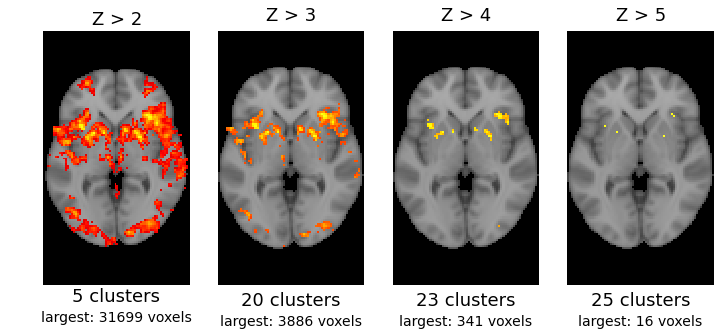

In [76]:
plt.figure(figsize=(12,10))
for thresh in [2,3,4,5]:
    idxdata=nibabel.load(os.path.join(studydir,'stats_OLS/zstat1_cluster_index_thresh%d.nii.gz'%thresh)).get_data()
    nvox=numpy.sum(idxdata==numpy.max(idxdata))
    nclust=len(numpy.unique(idxdata))
    print thresh,nvox
    ax1 = plt.subplot2grid((2,4), (0,thresh-2))
    plot=nilearn.plotting.plot_stat_map(os.path.join(studydir,'stats_OLS/zstat1_thresh_thresh%d.nii.gz'%thresh),
                        bgimage,threshold=thresh,
                        display_mode='z',cut_coords=[0],axes=ax1,
                        annotate=False,colorbar=False)
    xlim=plot.axes[0.0].ax.get_xlim()
    ylim=plot.axes[0.0].ax.get_ylim()
    
    plt.text(numpy.mean(xlim),ylim[1]+45,'Z > %d'%thresh,fontsize=18,horizontalalignment='center')
    plt.text(numpy.mean(xlim),ylim[0]-55,'%d clusters'%nclust,fontsize=18,horizontalalignment='center')
    plt.text(numpy.mean(xlim),ylim[0]-75,'largest: %d voxels'%nvox,fontsize=14,horizontalalignment='center')

plt.savefig(os.path.join(figuredir,'Figure_7_2.svg'),format='svg',dpi=1200)

__Figure 7.3__: Use manually generated original

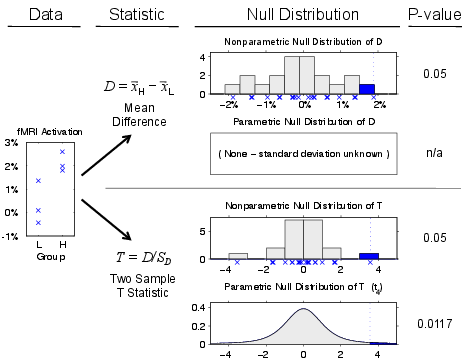

In [5]:
WImage(filename=os.path.join(orig_figuredir,'Figure_7_3.pdf'))

__Figure 7.4:__ Illustration of three different multiple comparison procedures. Each column corresponds to a different realization of signal plus noise as illustrated in the simulated data in the top row, and can be thought of as your next ten experiments. The top row shows the statistic image without any thresholding. The second row illustrates the control of the per comparison rate at 10%, that is, no special account of multiplicity. The third row shows control of the familywise error rate at 10%, say with RFT or Bonferroni. The bottom row shows control of the false discovery rate. With no adjustment for multiple testing (second row) there is excellent sensitivity, but very poor specificity – there are false positives everywhere. Controlling FWE (third row) gives excellent specificity – only 1 out of 10 experiments have any false positives— but poor sensitivity. Controlling FDR (bottom row) is a compromise between no correction and FWE correction, giving greater sensitivity at the expense of some false positives, even though it is still controlled as a fraction of all voxels detected. Note that, just as the emperical per comparison error rate for each experiment is never exactly 10%, likewise the emperical false discovery rate is never exactly 10%; in both instances, we’re guaranteed only that, in the long run, the average rate will not exceed 10%.

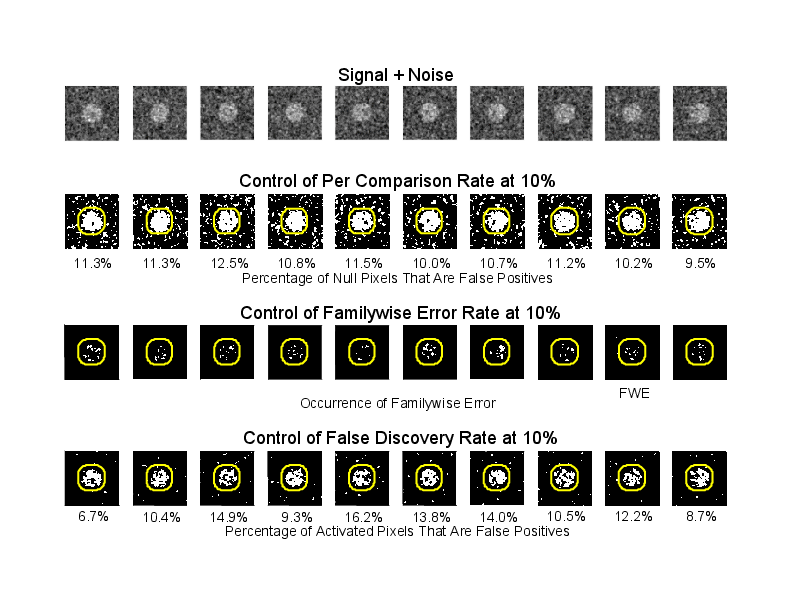

In [6]:
WImage(filename=os.path.join(orig_figuredir,'Figure_7_4.pdf'))

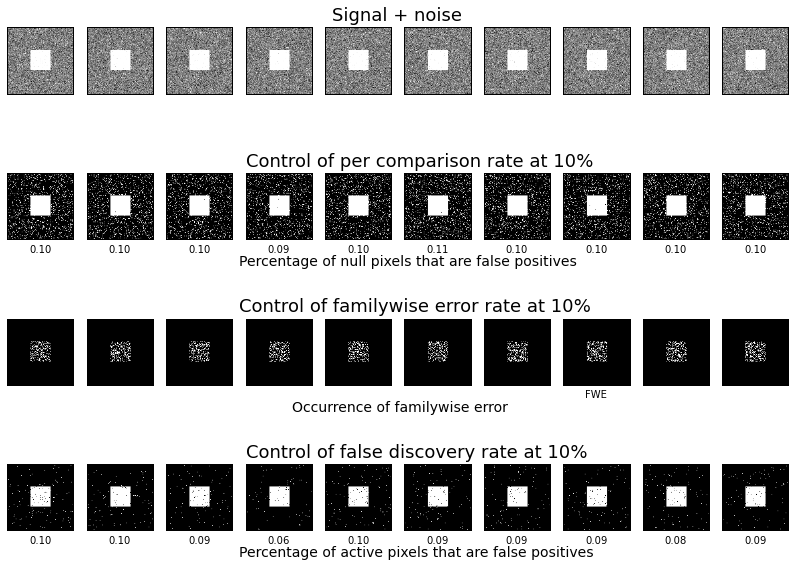

In [285]:
from statsmodels.stats.multitest import multipletests


# first generate 10 realizations of data

# fix seed to an example that gives one FWE
seed=95302
numpy.random.seed(seed) 

nsubs=24
img=numpy.zeros((100,100,nsubs)) 
baseimg=numpy.zeros((100,100))
baseimg[35:65,35:65]=1

for i in range(nsubs):
    img[:,:,i]=baseimg
onvox=numpy.where(baseimg==1)
offvox=numpy.where(baseimg==0)

images={}
tstat={}
pvals={}
noise_sd=1
pval=0.1

plt.figure(figsize=(14,10))

for i in range(10):
    data=img+numpy.random.randn(100,100,nsubs)*noise_sd
    images[i]=numpy.mean(data,2)
    t=scipy.stats.ttest_1samp(data,0,axis=2)
    tstat[i]=t.statistic
    pvals[i]=t.pvalue
    
    # plot raw values
    ax1 = plt.subplot2grid((4,10), (0,i))
    plot=plt.imshow(tstat[i],cmap='gray',vmin=-3,vmax=3)
    plt.xticks([])
    plt.yticks([])
    xlim=plot.axes.get_xlim()
    ylim=plot.axes.get_ylim()
    if i==4:
        plt.text(numpy.mean(xlim)-40,ylim[1]-10,'Signal + noise',
                fontsize=18)
        
    # plot uncorrected
    ax1 = plt.subplot2grid((4,10), (1,i))
    thresh_p=pvals[i]<pval
    plot=plt.imshow(thresh_p,cmap='gray',vmin=0,vmax=1)
    plt.xticks([])
    plt.yticks([])
    xlim=plot.axes.get_xlim()
    ylim=plot.axes.get_ylim()
    plt.text(numpy.mean(xlim),ylim[0]+20,'%0.2f'%float(numpy.mean(thresh_p[offvox])),
             horizontalalignment='center')
    if i==4:
        plt.text(numpy.mean(xlim)-170,ylim[1]-10,'Control of per comparison rate at 10%',
                fontsize=18)
        plt.text(numpy.mean(xlim)-180,ylim[0]+40,'Percentage of null pixels that are false positives',
                fontsize=14)
    
    # plot bonferroni control
    ax1 = plt.subplot2grid((4,10), (2,i))
    pval_array=pvals[i].ravel()
    _,corr_p,_,_=multipletests(pval_array,pval,'bonferroni')
    corr_p=corr_p.reshape(pvals[i].shape)
    sig=corr_p<pval
    #corr_p=pvals[i]*numpy.prod(pvals[i].shape)
    plot=plt.imshow(numpy.array(corr_p<pval).astype('int'),cmap='gray',vmin=0,vmax=1)
    plt.xticks([])
    plt.yticks([])
    xlim=plot.axes.get_xlim()
    ylim=plot.axes.get_ylim()
    if numpy.sum(sig[offvox])>0:
        plt.text(numpy.mean(xlim),ylim[0]+20,'FWE',
             horizontalalignment='center')
    if i==4:
        plt.text(numpy.mean(xlim)-180,ylim[1]-10,'Control of familywise error rate at 10%',
                fontsize=18)
        plt.text(numpy.mean(xlim)-100,ylim[0]+40,'Occurrence of familywise error',
                fontsize=14)
    
    # FDR control
    ax1 = plt.subplot2grid((4,10), (3,i))
    pval_array=pvals[i].ravel()
    _,corr_p,_,_=multipletests(pval_array,pval,'fdr_bh')
    corr_p=corr_p.reshape(pvals[i].shape)
    sig=corr_p<pval
    #corr_p=pvals[i]*numpy.prod(pvals[i].shape)
    plot=plt.imshow(numpy.array(corr_p<pval).astype('int'),cmap='gray',vmin=0,vmax=1)
    plt.xticks([])
    plt.yticks([])
    xlim=plot.axes.get_xlim()
    ylim=plot.axes.get_ylim()
    fdr_obs=numpy.sum(sig[offvox])/numpy.sum(sig)
    plt.text(numpy.mean(xlim),ylim[0]+20,'%0.2f'%fdr_obs,
             horizontalalignment='center')
    if i==4:
        plt.text(numpy.mean(xlim)-170,ylim[1]-10,'Control of false discovery rate at 10%',
                fontsize=18)
        plt.text(numpy.mean(xlim)-180,ylim[0]+40,'Percentage of active pixels that are false positives',
                fontsize=14)

plt.savefig(os.path.join(figuredir,'Figure_7_4.svg'),format='svg',dpi=1200)

__Figure 7.5:__ Thresholded maps from the gambling experiment, parametric effect of the size of potential loss on BOLD response. Top (a) shows clusters created with Z = 2.3 cluster-forming threshold and no cluster-size threshold, while bottom (b) shows the 3 clusters that survive a critical cluster size threshold of 570 voxels.
 

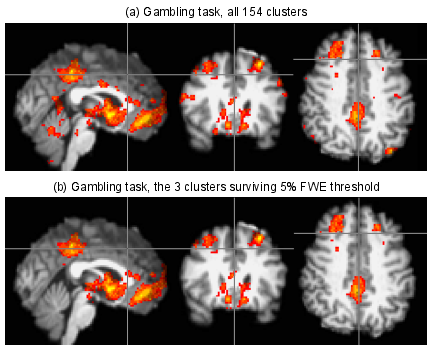

In [7]:
WImage(filename=os.path.join(orig_figuredir,'Figure_7_5.pdf'))

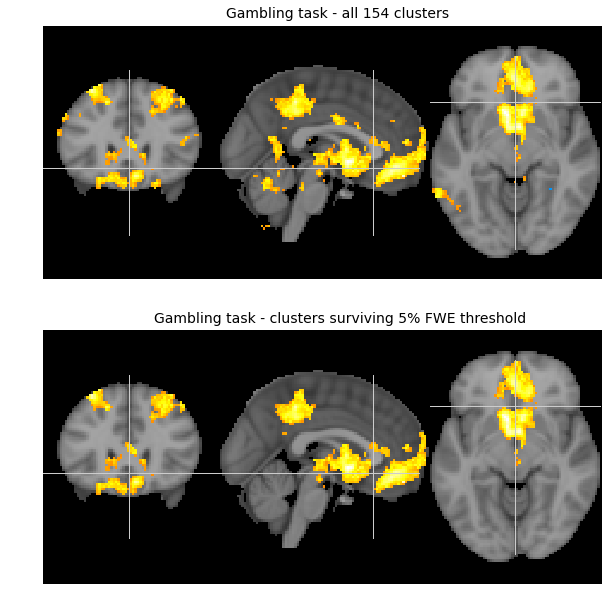

In [329]:
zstat_cope3=nibabel.load(os.path.join(datadir,'ds005/ds005_cope3_zstat2.nii.gz'))
bgimage=nibabel.load(os.path.join(os.getenv('FSLDIR'),'data/standard/MNI152_T1_2mm_brain.nii.gz'))

plt.figure(figsize=(10,10))
ax1 = plt.subplot2grid((2,1), (0,0))
plot=nilearn.plotting.plot_stat_map(zstat_cope3,
                        bgimage,threshold=2.3,
                        display_mode='ortho',axes=ax1,
                        annotate=False,colorbar=False)
xlim=plot.axes['y'].ax.get_xlim()
ylim=plot.axes['y'].ax.get_ylim()
plt.text(numpy.mean(xlim)-240,ylim[1]+15,'Gambling task - all 154 clusters',
                fontsize=14)
# perform clustering
cl = mem.cache(fsl.Cluster)
clustidx=os.path.join(datadir,'ds005/ds005_cope3_zstat2_clustidx.nii.gz')
if not os.path.exists(clustidx):
    cluster_results=cl(threshold = 2.3,
        in_file = os.path.join(datadir,'ds005/ds005_cope3_zstat2.nii.gz'),
        out_index_file=clustidx)
clustimg=nibabel.load(clustidx)
clustdata=clustimg.get_data()

nclust=numpy.max(clustdata)
extent_thresh=570
for i in range(1,nclust+1):
    if numpy.sum(clustdata==i)<extent_thresh:
        clustdata[clustdata==i]=0
clustdata[clustdata>0]=1

zstatdata=nibabel.load(os.path.join(datadir,'ds005/ds005_cope3_zstat2.nii.gz')).get_data()
clust_extent_thresh=nibabel.Nifti1Image(clustdata*zstatdata,clustimg.get_affine(),clustimg.get_header())
clust_extent_thresh.to_filename(os.path.join(datadir,
                        'ds005/ds005_cope3_zstat2_extentthresh.nii.gz'))

ax1 = plt.subplot2grid((2,1), (1,0))
plot=nilearn.plotting.plot_stat_map(clust_extent_thresh,
                        bgimage,threshold=2.3,
                        display_mode='ortho',axes=ax1,
                        annotate=False,colorbar=False)
xlim=plot.axes['y'].ax.get_xlim()
ylim=plot.axes['y'].ax.get_ylim()
plt.text(numpy.mean(xlim)-300,ylim[1]+15,'Gambling task - clusters surviving 5% FWE threshold',
                fontsize=14)


__Figure 7.6:__ Use original manaully generated art

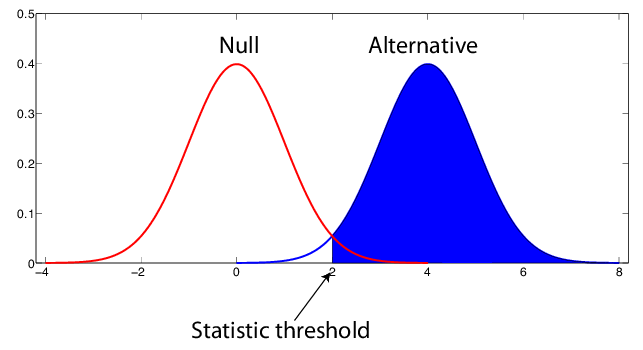

In [8]:
WImage(filename=os.path.join(orig_figuredir,'Figure_7_6.pdf'))

__Figure 7.7:__ Power curve. The curve was generated using an estimated mean effect of 0.8% signal change units with standard deviation of 2% signal change units and a type I error rate of 0.05 using Equation 7.2. Since the graph crosses 80% between 40 and 41 subjects, a sample size of 41 will yield at least 80% power.

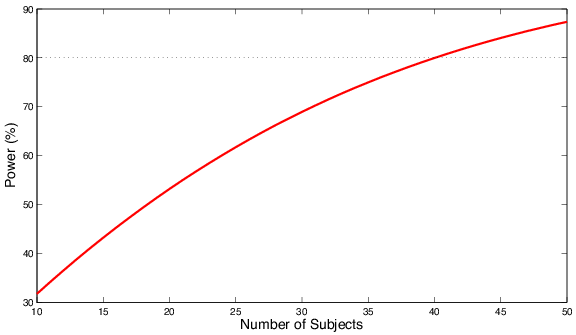

In [9]:
WImage(filename=os.path.join(orig_figuredir,'Figure_7_7.pdf'))

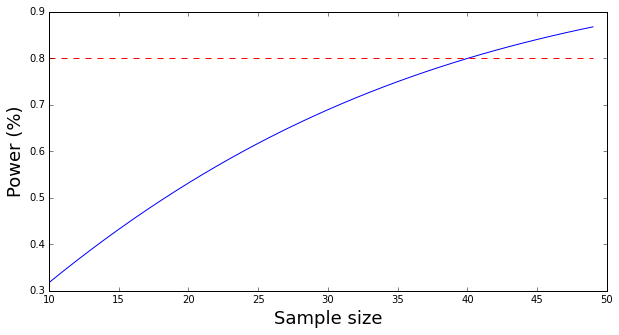

In [298]:
mu=0.8
sigma=2.0
alpha=0.05
N=41

def power(mu,sigma,N):
    ncp=(numpy.sqrt(N)*mu)/sigma
    nct= scipy.stats.nct(N-1, ncp)
    t=scipy.stats.t.ppf(1-alpha,N-1)
    return 1 - nct.cdf(t)

nvals=range(10,50)
p=numpy.zeros(len(nvals))
for i in range(len(nvals)):
    p[i]=power(mu,sigma,nvals[i])
    
plt.figure(figsize=(10,5))
plt.plot(nvals,p)
plt.plot([numpy.min(nvals),numpy.max(nvals)],[0.8,0.8],color='red',linestyle='--')
plt.xlabel('Sample size',fontsize=18)
plt.ylabel('Power (%)',fontsize=18)
plt.savefig(os.path.join(figuredir,'Figure_7_7.svg'),format='svg',dpi=1200)